# Simulation studies using Mixedmodels

The most noticeable advantages of fitting mixed-effects models using the [`MixedModels`](https://github.com/dmbates/MixedModels.jl) package for [Julia](https://julialang.org) relative to, say, [`lme4`](https://github.com/lme4/lme4) in [R](https://www.r-project.org) are speed and reliability.

For simple models fit to data sets of modest size, speed is not that much of an issue.  If the model can be fit in less time than it takes to organize and plot the data to determine an appropriate model form then it is not too important if one implementation is faster than another.

However, in a simulation study that may involve tens or hundreds of thousands of model fits speed of fitting even simple models can be important.  The purpose of this notebook is to show how to perform simulation studies in Julia quickly and efficiently. The emphasis will be on simulation of linear mixed-effects models but many of the techniques and software practices apply more generally.

## Overall strategy

It is almost trivial to state that the purpose of a simulation study is to generate a set of simulated values that we can use to assess whether a claim is reasonable.  By the way, it is important to realize that a simulation study can only refute a claim by showing that the observed results are inconsistent with that claim.  You cannot establish a result through a simulation study.  You can only show that your results in a particular case are non inconsistent with the claim.

As with any other experiment it helps to determine up front what the scope of the study should be and what information from the study should be retained.  The design space for the study can be very large, even for a simple case such as assessing the characteristics (Type I error and power) of a particular test, as described below.  Also the amount of information generated can be very large and the expense of retaining a huge amount of information must be balanced with information loss by summarizing.  There is a great temptation to perform too much data reduction, such as recording only the proportion of p-values falling below a threshold in a test.  Retaining the simulated p-values themselves provides a richer source of information.

A basic rule in Julia is that, because of the way just-in-time (JIT) compilation works, any substantial computation should take place within a function. Thus the early phases of the simulation study are exercises in designing functions. In the later phases these functions should be wrapped in a package.

## A simple example

In Matuschek, Kliegl, Vasishth, Baayen and Bates (2017) we used a simulation study to explore "Balancing Type I Error and Power in Linear Mixed Models".  The experimental design consisted of a single binary experimental factor, `C`, which varied within subjects (`S`) and within items (`I`).  There are `m` items and `n` subjects.

Begin by loading the packages to be used.  The `MixedModels` package is obviously needed to define and fit the models as is the `DataFrames` package for the data representation.  The `Distributions` package provides the complementary cumulative distribution function (`ccdf`) to evaluate p-values from test statistics assuming a given reference distribution, and the `Gadfly` package is used for plotting.

In [1]:
using Distributions, DataFrames, Gadfly, Iterators, MixedModels

Define a `mkdata` function to generate a data frame according to the number of subjects, the number of items, and the coding of the levels of the covariates. (My coauthors in that paper overruled me and used a `[-0.5, 0.5]` encoding. Here I use the `[-1, 1]` encoding preferred by statisticians.)

In [2]:
function mkdata(m=10, n=30)
    chars = vcat('A':'Z', 'a':'z')
    tuples = collect(product(['N','Y'], ('a':'z')[1:m], chars[1:n]))
    vecs = push!(Any[pool(getindex.(tuples, i)) for i in 1:3], 
        zeros(length(tuples)))
    DataFrame(vecs, [:C, :I, :S, :Y])
end


mkdata (generic function with 3 methods)

In [3]:
const dat = mkdata()

,C,I,S,Y
1,N,a,A,0.0
2,Y,a,A,0.0
3,N,b,A,0.0
4,Y,b,A,0.0
5,N,c,A,0.0
6,Y,c,A,0.0
7,N,d,A,0.0
8,Y,d,A,0.0
9,N,e,A,0.0
10,Y,e,A,0.0


In [4]:
typeof.(dat.columns)  # check the column types

4-element Array{DataType,1}:
 DataArrays.PooledDataArray{Char,UInt8,1}
 DataArrays.PooledDataArray{Char,UInt8,1}
 DataArrays.PooledDataArray{Char,UInt8,1}
 Array{Float64,1}                        

The response, `Y`, is initialized to zeros so that it is available to construct `LinearMixedModel` objects. The `const` modifier in the assignment indicates that the type of `dat` will not change, although the actual data values may change (but in this case they won't).  Using `const`, if appropriate, when assigning global variables is a good practice.

The `lmm` function creates, but does not fit, a `LinearMixedModel`.  It is useful to have a model that has not yet been fit because it is the structure that can then be used to `simulate!` a response and `refit!` the model.

The formula for the linear mixed-effects model can be constructed with the `@formula` macro or using an explicit call to the `Formula` constructor.  For example

In [5]:
srand(1234321)
refit!(simulate!(lmm(@formula(Y ~ 1 + (1|S) +(1|I)), dat), 
        β=[2000.], σ=300., θ=fill(1/3, 2)))

Linear mixed model fit by maximum likelihood
 Formula: Y ~ 1 + (1 | S) + (1 | I)
     logLik       -2 logLik         AIC            BIC      
 -4.3350137×10³  8.6700273×10³  8.6780273×10³   8.695615×10³

Variance components:
              Column    Variance   Std.Dev.  
 S        (Intercept)   14072.258 118.626547
 I        (Intercept)    4291.301  65.508023
 Residual              101303.824 318.282617
 Number of obs: 600; levels of grouping factors: 30, 10

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   1955.61   32.6657 59.8675  <1e-99


or

In [6]:
srand(1234321)
const m0 = refit!(simulate!(lmm(Formula(:Y,:(1+(1|S)+(1|I))), dat),
        β=[2000.], σ=300., θ=fill(1/3, 2)))

Linear mixed model fit by maximum likelihood
 Formula: Y ~ 1 + (1 | S) + (1 | I)
     logLik       -2 logLik         AIC            BIC      
 -4.3350137×10³  8.6700273×10³  8.6780273×10³   8.695615×10³

Variance components:
              Column    Variance   Std.Dev.  
 S        (Intercept)   14072.258 118.626547
 I        (Intercept)    4291.301  65.508023
 Residual              101303.824 318.282617
 Number of obs: 600; levels of grouping factors: 30, 10

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   1955.61   32.6657 59.8675  <1e-99


We obtain the simulated response and fit the alternative model as

In [7]:
const y0 = model_response(m0)
const m1 = refit!(lmm(Formula(:Y, :(1+C+(1|S)+(1|I))), dat), y0)

Linear mixed model fit by maximum likelihood
 Formula: Y ~ 1 + C + (1 | S) + (1 | I)
     logLik       -2 logLik         AIC            BIC      
 -4.3350099×10³  8.6700198×10³  8.6800198×10³  8.7020044×10³

Variance components:
              Column    Variance   Std.Dev. 
 S        (Intercept)   14072.327 118.62684
 I        (Intercept)    4291.324  65.50820
 Residual              101302.465 318.28048
 Number of obs: 600; levels of grouping factors: 30, 10

  Fixed-effects parameters:
             Estimate Std.Error    z value P(>|z|)
(Intercept)   1956.74   35.1552    55.6601  <1e-99
C: Y         -2.25397   25.9875 -0.0867329  0.9309


The likelihood ratio test statistic for `H₀: β₂ = 0` versus `Hₐ: β₂ ≠ 0` is the difference in the objective (negative twice the log-likelihood) values for the fitted models.

In [8]:
lrtval = objective(m0) - objective(m1)

0.0075225519667583285

The p-value, assuming a `Chisq(1)` reference distribution, is

In [9]:
ccdf(Chisq(1), lrtval)

0.9308840260438832

Notice that the conclusions from the likelihoood ratio test are essentially the same as those from the Z test on `β₂` in the coefficient summary table
```
  Fixed-effects parameters:
             Estimate Std.Error  z value P(>|z|)
(Intercept)   1955.61   34.7294    56.31  <1e-99
C             5.81124    12.988 0.447432  0.6546
```
for the alternative model `m1`.  This is because the square of the `z` value, which is the ratio of the estimate of `β₂` to its standard error, is essentially the same as `lrtval`

In [10]:
abs2(0.447432)

0.200195394624

and a `Chisq(1)` distribution is the square of a standard normal distribution.

Generally a hypothesis test based on fitting both the null model and the alternative model to the data (i.e. the likelihood ratio test) is more reliable than one based on fitting only the alternative model and inferring what the change to the null model fit will be (the Z-statistic).  In this case they give essentially the same results.

## Plotting the data

Although it is tempting to continue with writing simulation functions, this is a good time to examine the responses that have been simulated. What do we expect them to look like?

To make it more convenient to plot the data we copy the contents of `y0` vector to the `:Y` column of the data frame then look for a systematic shift

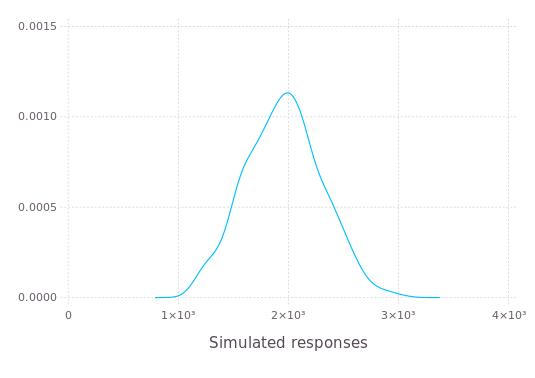

In [11]:
copy!(dat[:Y], y0)
plot(dat, x = :Y, Geom.density, Guide.xlabel("Simulated responses"))

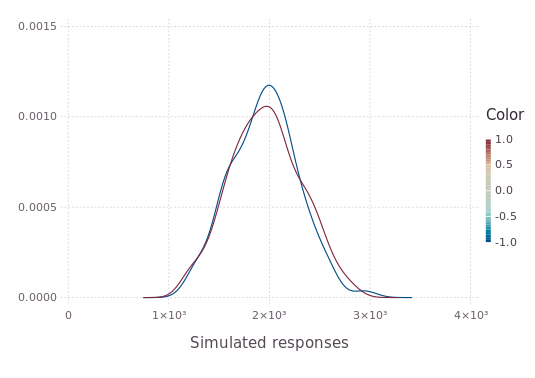

In [14]:
plot(dat, x = :Y, Geom.density, Guide.xlabel("Simulated responses"),
    color = :C)

There is no evidence of a systematic shift according to the level of the condition, `C`, which is what we would expect because we simulated the data from the null model.

Next consider the effect of the subjects and items

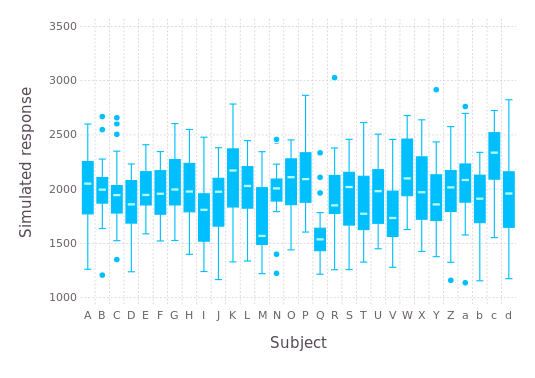

In [15]:
plot(dat, x = :S, y = :Y, Geom.boxplot, Guide.xlabel("Subject"),
    Guide.ylabel("Simulated response"))

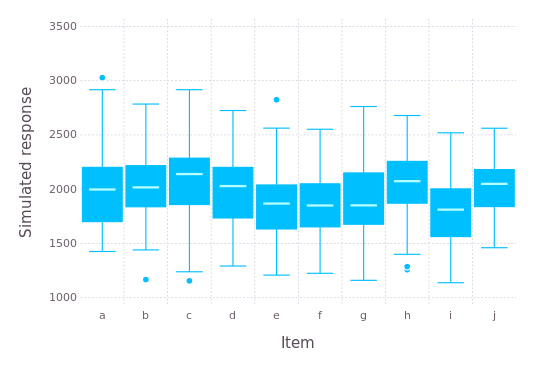

In [16]:
plot(dat, x = :I, y = :Y, Geom.boxplot, Guide.xlabel("Item"),
    Guide.ylabel("Simulated response"))

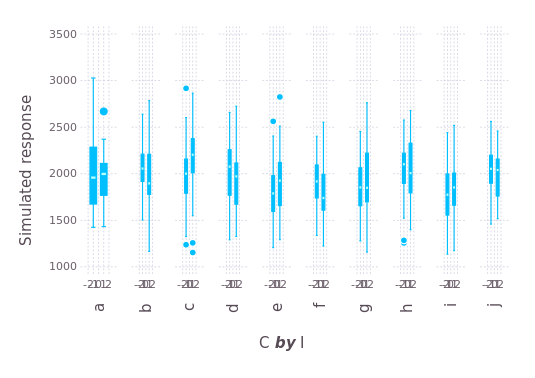

In [17]:
plot(dat, x = :C, y = :Y, xgroup=:I, Geom.subplot_grid(Geom.boxplot),
    Guide.ylabel("Simulated response"))

None of these plots show much structure in the data but that is not surprising because these data were simulated from the null model.  Notice that, even though there are simulated random effects for subject and for item the differences between groups are not substantial.

## Simulating p values from a single test

In [18]:
function onetest(mods::Vector{LinearMixedModel{T}},
        N, β::Vector{T}, σ::T, θ::Vector{T}) where {T}
    if length(mods) ≠ 2
        throw(ArgumentError(
                "length(mods) == $(length(mods)) should be 2"))
    end
    obj1 = Vector{T}(N)
    obj2 = similar(obj1)
    lrt = similar(obj1)
    pvalue = similar(obj1)
    for i in 1:N
        obj1[i] = o1 = objective(refit!(simulate!(mods[1],
            β=β, σ=σ, θ=θ)))
        obj2[i] = o2 = objective(refit!(mods[2],
            model_response(mods[1])))
        lrt[i] = l = o1 - o2
        pvalue[i] = ccdf(Chisq(1), l)
    end
    DataFrame(Any[obj1, obj2, lrt, pvalue], [:d1, :d2, :lrt, :p])
end
srand(1234321)
const mods = [lmm(Formula(:Y,:(1+(1|S)+(1|I))), dat),
        lmm(Formula(:Y,:(1+C+(1|S)+(1|I))), dat)]
onetest(mods, 10, [2000.], 300., fill(1/3, 2))      

,d1,d2,lrt,p
1,8671.091356771725,8670.891196705816,0.20016006590958568,0.6545916764466219
2,8518.58508482889,8518.576999653615,0.00808517527548247,0.9283526928822893
3,8607.158621420116,8604.255611491397,2.903009928719257,0.08841431801385548
4,8608.24386521171,8607.930549439729,0.3133157719821611,0.5756525870421703
5,8628.640317127587,8627.431766768537,1.2085503590496955,0.2716194097174946
6,8608.446167225378,8607.984611916829,0.4615553085495776,0.49689799337512186
7,8568.928534709537,8565.39625762021,3.532277089327181,0.060185078588347124
8,8584.746438214455,8584.739008982322,0.007429232133290498,0.9313130003358725
9,8570.875795366848,8569.045405289717,1.8303900771315966,0.1760814784693937
10,8639.339367730969,8638.180480969655,1.1588867613136244,0.2816965360177137


In [19]:
@time const rr =  onetest(mods, 10000, [2000.], 300., fill(1/3, 2));

 25.967717 seconds (84.37 M allocations: 3.061 GiB, 3.25% gc time)


In [20]:
const ppts250 = inv(500):inv(250):1

0.002:0.004:0.998

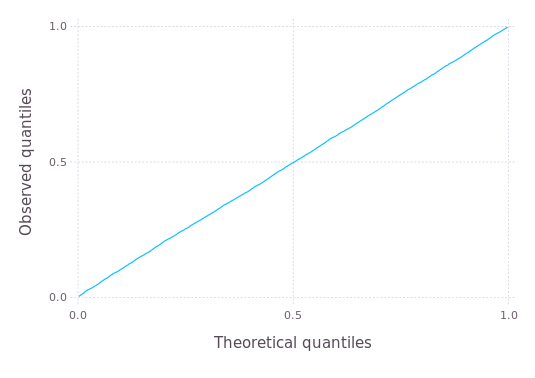

In [21]:
plot(x = ppts250, y = quantile(rr[:p], ppts250), Geom.line,
    Guide.xlabel("Theoretical quantiles"), 
    Guide.ylabel("Observed quantiles"))

The so-called "maximal" model for such an experimental design is

In [ ]:
const maxmod = lmm(@formula(Y ~ 1+C+(1+C|S)+(1+C|I)), dat);

To simulate a response we specify the fixed-effects parameters, `β`, the standard deviation of the per-observation noise, `σ`, and the relative covariance parameters, `θ`.  `β` and `θ` are vectors whereas `σ` is a scalar.  For this model `β` is of length 2 and `θ` is of length 6.  In this simulation the null hypothesis is that the second element of `β` is zero.

In [ ]:
srand(1234321)   # set the random number seed
refit!(simulate!(maxmod, β=[2000.,0.], σ=300., θ=[1/3,0.,0.,1/3,0.,0.]))

The value of `θ` corresponds to random intercepts only with a standard deviation of 100 for subject and for item.

The null model for a likelihood ratio test is

In [ ]:
const nullmod = lmm(@formula(Y ~ 1 + (1+C|S) + (1+C|I)), dat);
refit!(nullmod, model_response(maxmod))

#### Note for statisticians

> Testing the significance of the main effect for `C` in the presence of apparently non-ignorable interactions of `C` with `S` and with `I`, as done here, is quite peculiar. Some would say nonsensical.  Unfortunately, this practice has become enshrined in the subject matter literature so we include such nonsense comparisons in the simulation.

The likelihood ratio test statistic for these two model fits is

In [ ]:
const lrtstat = objective(nullmod) - objective(maxmod)

The p-value for the likelihood ratio test, assuming a χ² reference distribution with 1 degree of freedom, is

In [ ]:
ccdf(Chisq(1), lrtstat)  # ccdf -> complementary cumulative dist fcn

Notice that this is essentially the same result as for the Z test described in the line for `C` in the coefficient table of `maxmod`
```
  Fixed-effects parameters:
             Estimate Std.Error  z value P(>|z|)
(Intercept)   1952.75   26.8259  72.7934  <1e-99
C             5.81124   16.4813 0.352595  0.7244
```
This is because the `z-value`, which is the ratio of the coefficient estimate and its approximate standard error, is very close to the square root of `lrtstat`

In [ ]:
sqrt(lrtstat)

## Repeating the simulation

The whole purpose of a simulation study is to repeat the process of simulating a response vector and fitting various models to it many times. Because Julia performs just-in-time (JIT) compilation on methods it is important to perform such repetitive operations within a function call.  This is one of the most important lessons in using Julia efficiently - if you have any doubt about whether an operation should be done in a function or in global scope, do it in a function.

To assess the Type I error rate we will simulate data from the null model `1+(1|S)+(1|I)` and evaluate the likelihood ratio test statistic for the fit of `1+(1|S)+(1|I)` versus `1+C+(1|S)+(1|I)`

In [ ]:
function typeIsim(seed, N, null::LinearMixedModel{T},
    alt::LinearMixedModel{T}, β::Vector{T}, σ::T, θ::Vector{T}) where T
    srand(seed)
    refdist = Chisq(1)
    r = Matrix{T}(4,N)
    for j in 1:N
        r[1,j] = objn = objective(refit!(simulate!(null, β=β, σ=σ, θ=θ)))
        r[2,j] = obja = objective(refit!(alt, model_response(null)))
        r[3,j] = lrtstat = objn - obja
        r[4,j] = ccdf(refdist, lrtstat)
    end
    r
end

We fill out the matrix `r`, which will be the returned value, one column at a time because matrices in Julia are stored in [*column-major*](https://en.wikipedia.org/wiki/Row-_and_column-major_order) order.

First, run a small test to make sure things are working as expected

In [ ]:
typeIsim(1234321, 10, lmm(@formula(Y~1+(1|S)+(1|I)), dat),
   lmm(@formula(Y~1+C+(1|S)+(1|I)), dat), [2000.], 300., [1/3,1/3])

In [ ]:
using Gadfly

In [ ]:
@time const r = typeIsim(1234321, 10000, lmm(@formula(Y~1+(1|S)+(1|I)), dat),
   lmm(@formula(Y~1+C+(1|S)+(1|I)), dat), [2000.], 300., [1/3,1/3])

In [ ]:
plot(x=view(r, 4, :), Geom.histogram, Guide.xlabel("p-values"))

In [ ]:
const ppt250 = inv(500) : inv(250) : 1
plot(x=quantile(view(r,4,:), ppt250), y = ppt250, Geom.line)

In [ ]:
const nullrhs = [
    :(1+(1+C|S)+(1+C|I)),     # "maximal" model
    :(1+(1|S)+(0+C|S)+(1|I)+(0+C|I)), # uncorrelated intercept/slope
    :(1+(1|S)+(0+C|S)+(1|I)), # uncorrelated subject intercepts/slope 
    :(1+(1|S)+(1|I)+(0+C|I)), # uncorrelated item intercept/slope
    :(1+(1|S)+(1|I))];        # random intercepts only.

(Statisticians may find all but the last of these models to be peculiar because they are used to test the significance of a main effect in the presence of apparently non-ignorable interactions with grouping factors for the random effects.  They are indeed peculiar; some would say nonsensical.  Unfortunately this nonsensical approach is now enshrined in the subject matter literature.)

In [ ]:
const altrhs = deepcopy(nullrhs);  # modify a copy of the null models
for expr in altrhs
    insert!(expr.args, 3, :C)  # add the main effect for C
end
altrhs

Just to check that we haven't accidently changed the null right-hand sides

In [ ]:
nullrhs

Now generate `LinearMixedModel` objects for each of these formulas.

In [ ]:
const nullmods = [lmm(Formula(:Y,rhs), dat) for rhs in nullrhs];

In [ ]:
const altmods = [lmm(Formula(:Y,rhs), dat) for rhs in altrhs];

In [ ]:
getfield.(altmods, :formula)

### Creating a single simulated response vector

The `simulate!` function takes a `LinearMixedModel` and optional parameter values and overwrites the response with a simulated response.

For convenience we will always simulate from the "maximal" alternative because all the other models can be represented as special cases of that model with restricted parameter values.

In [ ]:
refit!(simulate!(altmods[1], 
    β=[2000.,0.], σ = 300., θ = [1/3,0.,0.,1/3,0.,0.]))

In [ ]:
newy = model_response(altmods[1]);

In [ ]:
refit!(nullmods[1], newy)

In [ ]:
objective(altmods[1]) - objective(nullmods[1])